### Assignment 5 
Implementation of Qlearning and Neural Qlearning through a MLP

Authors: Abdullahi Ali, Pieter Wolfert

In [1]:
from my_env import EvidenceEnv
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.style.use('ggplot')

Define randomagent. Given in the assignment. 

In [2]:
class RandomAgent(object):

    def __init__(self, env):
        self.env = env

    def act(self, observation):
        return np.random.choice(self.env.n_action)

    def train(self, a, old_obs, r, new_obs):
        pass        

Training loop for the random agent.

In [3]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
agent = RandomAgent(env)
#reset environment and agent
obs = env.reset()
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    #no training involved for random agent
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)

### Assignment 1 
Plot of the cumulative reward.

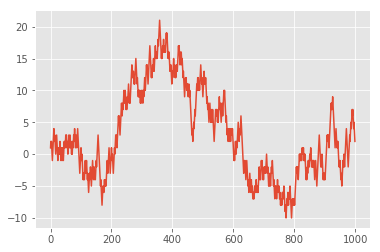

In [4]:
plt.plot(R)
plt.show()

### Assignment 2
Implementation of tabular Q-learning

In [5]:
class TabularAgent(object):

    def __init__(self, env):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.2
        self.gamma = 0.9
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_Q = self.Q[old_obs, a]
        self.Q[old_obs, a] = self.Q[old_obs, a] + \
            self.lr*(r + self.gamma*(self.Q[new_obs, self.act(new_obs)]) - self.Q[old_obs, a])

#### Training
Training loop for learning the Q value with the Q learning algorithm.

In [6]:
# number of iterations
n_iter = 1000
#environment specs
tab_env = EvidenceEnv(n=2, p=0.95)
agent = TabularAgent(tab_env)
Q_before = agent.get_Q()
obs = tab_env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = tab_env.step(action)
    _obs = tab_env.asint(_obs)
    agent.train(action, obs, r, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

Plot of the cumulative reward. 

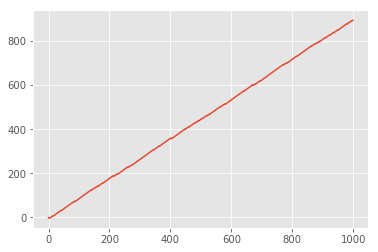

In [7]:
plt.plot(R)
plt.show()

Plot of the Q values before and after learning. 

<function matplotlib.pyplot.show>

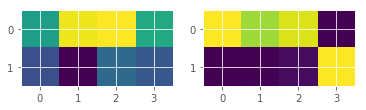

In [8]:
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show

### Assignment 3
Implementation of NeuralQAgent

In [9]:
class NeuralQAgent(object):

    def __init__(self, env, model, classifier, optimizer):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.10
        self.gamma = 0.9
        self.model = model
        self.classifier = classifier
        self.optimizer = optimizer
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_obs, new_obs = np.array(self.env.asbinary(old_obs, 2)), np.array(self.env.asbinary(new_obs, 2))
        self.classifier.cleargrads()
        predictionMaxQ = np.max(self.classifier(new_obs.astype('float32')).data)
        Qtarget = r + self.gamma*predictionMaxQ
        targets = np.zeros((self.env.n_action))
        targets[a] = Qtarget
        y = classifier(old_obs.astype('float32')).data[1]
        self.Q[old_obs, a] = y
        loss = 0.5*F.sum(F.squared_error(y.astype('float32'), targets.astype('float32')))
        loss.backward()
        self.optimizer.update()

#### Network Structure
Chainer is used to define the structure for the MLP.

In [10]:
class MLP(Chain):
    """
    
    Implementation of a 3-layer Multilayer Perceptron
    
    """
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Hidden layer
            self.l2 = L.Linear(n_units, n_out) # Output layer
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        output = self.l2(h1)
        return output
  
class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x):
        x = F.expand_dims(x,1)
        y = self.predictor(x)
        #loss = F.mean_squared_error(y, t)
        return y

#### Training
An MLP learns the Q value (optimal policy). 

In [11]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
model = MLP(2, 2)
classifier = Regressor(model)
optimizer = optimizers.SGD()
optimizer.setup(classifier)
agent = NeuralQAgent(env, model, classifier, optimizer)
#reset environment and agent
Q_before = agent.get_Q()
obs = env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    _obs = env.asint(_obs)
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

#### Cumulative Reward
This plot shows the cumulative reward (summation of rewards over time). 

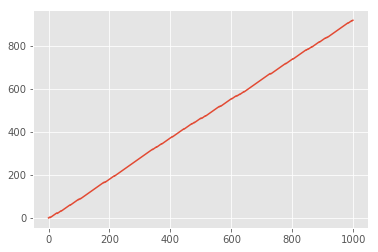

In [12]:
plt.plot(R)
plt.show()

This plot shows the randomized Q values (Q_before) and the learned Q values (Q_after).

<function matplotlib.pyplot.show>

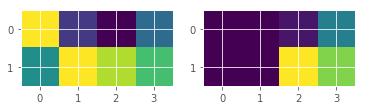

In [13]:
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show